# Particle tracking tutorial: Detection of particles

#### This tutorial intends to compare different methods for the detection of particles from image files, both from experimental data and simulations. It relies on a number of Python packages, including Deeptrack, matplotlib, TensorFlow and PyTorch.

### Run the following command in the terminal to install the necessary libraries:

#### MacOS:

pip install numpy torch matplotlib tensorflow scikit deeptrack python3-tk trackpy

#### Linux:

sudo apt-get install numpy torch matplotlib tensorflow scikit deeptrack python3-tk trackpy

### 1. Initialize all the necessary libraries

In [1]:
import tkinter as tk # Package for GUI
from tkinter import filedialog #File selector using file explorer/Finder
import matplotlib.pyplot as plt # Plotting package
import skimage # Image analysis (scikit)
import numpy as np # Scientific computing using arrays
import scipy # Optimized for linear algebra, signal processing
import deeptrack as dt # DeepTrack
import imageio # Creates images/video from data
import cv2 # opencv (Computer Vision)
#import mpld3 # Interactive plots integrated in matplotlib using Jupyter notebooks
import trackpy as tp # Particle tracking package. Contains Crocker & Grier method

/opt/anaconda3/envs/MAGIK/lib/python3.10/site-packages/deeptrack/backend/_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
/opt/anaconda3/envs/MAGIK/lib/python3.10/site-packages/deeptrack/backend/_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")
2024-10-01 09:25:48.282903: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/envs/MAGIK/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 

### 2. Visualization of an experiment
#### A file selector window will pop up. Select an image containing particles to be visualized

In [2]:
# Uses tkinter library as tk and tkinter.filedialog

# Create a root window and hide it (not needed to be displayed)
#root = tk.Tk()
#root.withdraw()

#image_path = filedialog.askopenfilename(title="Select experimental image") #Fetch the image file and save the path into a string

# Print the name of the selected file
#print("Selected file:", image_path)

In [3]:
image_path = "/Users/aarondomenzain/Desktop/PhD/Particle Tracking Project/tracking-softmatter-main/data/PS_Optical_01.tif"

#### Visualize the loaded image using SciKit 

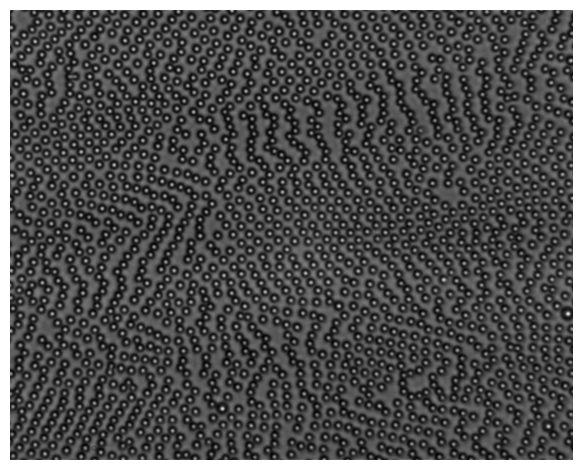

In [4]:
#Open figure instance
plt.figure()

# Instance of the loaded file
image = skimage.io.imread(image_path)
image=image[:,:,0] #Slice one frame if image file is a video

plt.imshow(image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

#### Manually select and display a single object

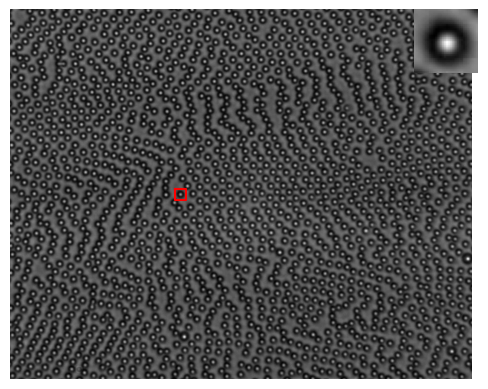

In [5]:
width = 30 #Window size to zoom in an individual particle
x = 512 - width // 2 # Position of the window
y = 472 - width // 2

crop = image[x:x+width, y:y+width] # 

fig = plt.figure() # Start the figure instance in matplotlib

# Draw a red rectangle around the crop
fig.add_subplot(111)
plt.imshow(image, cmap='gray')
plt.plot([y, y+width, y+width, y, y], [x, x, x+width, x+width, x], 'r-')
plt.axis('off')

fig.add_subplot(555)
plt.imshow(crop, cmap='gray')
plt.axis('off')

#plt.savefig('../figures/fig_20_02.png', dpi=300)
plt.show()

## 2. Use DeepTrack to simulate a realistic image to test the performance of diferent methods. 


#### DeepTrack can be used to simulate physically realistic scenarios, which can be also used to train neural network models.
##### deeptrack.Sphere: A spherical particle is defined by dimensions and intensities set by the user.This is used to simulate a spherical core with a surrounding shell.
##### deeptrack.Fluorescence: Optical properties are set to simulate the characteristics of a fluorescence microscope.



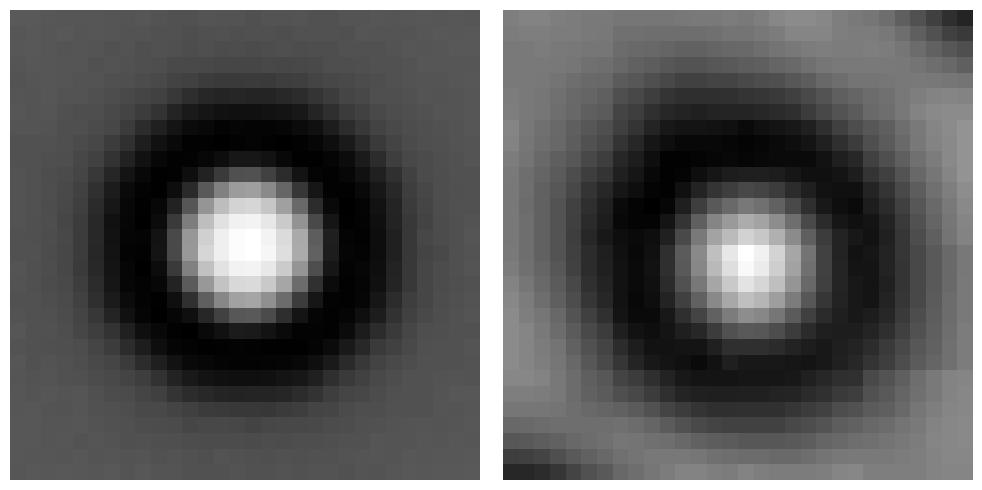

In [6]:
#import deeptrack as dt
from skimage import filters

IMAGE_SIZE = 30 #Same as when selecting a single object

# Define a central spherical scatterer of 450 nm at a random position inside the selection box
inner_sphere = dt.Sphere(
        position=lambda: np.random.uniform(
		    IMAGE_SIZE / 2 - 1, 
		    IMAGE_SIZE / 2 + 1, 
		    size=2
	    ), 
    radius= 450 * dt.units.nm, # Radius in nm (default meter)
    #lambda: np.random.uniform(0.005e-6, 0.5e-6),
    intensity= 1200,  # # Squared magnitude of the field
)

# Define a surrounding shell with a radius of 2.2 times the radius of the spherical core
outer_sphere = dt.Sphere(
    position=inner_sphere.position,
    radius=inner_sphere.radius * 2.2, #Outer sphere must be bigger than inner sphere
    inner_intensity=inner_sphere.intensity,
    factor=-.2,
    intensity=lambda inner_intensity, factor: inner_intensity * factor,
)

# Instance containing the core + shell spheres
combined_sphere = inner_sphere >> outer_sphere

# Simulate the properties of the fluorescence microscope
optics = dt.Fluorescence(
    NA = 1.4,  # Numerical aperture
    wavelength= 638. * dt.units.nm,  # Wavelength
    refractive_index_medium= 1.33, 
    output_region= [0, 0, IMAGE_SIZE, IMAGE_SIZE],
    magnification= 1,
    resolution= 100* dt.units.nm,  # Wavelength,  # Camera resolution or effective resolution
    return_field = False,
    )

scale_factor = (
    (
        optics.magnification()
        * optics.wavelength()
        / (optics.NA() * optics.resolution())
    )
    ** 2
) * (1 / np.pi)


sim_crop = optics(combined_sphere) >> dt.Divide(scale_factor) >> dt.Add(80) >> dt.Gaussian(0,.5) #>> dt.Lambda( lambda s: lambda x: filters.gaussian(x, sigma=s), s=1.2)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(sim_crop()), cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(crop, cmap="gray")

plt.axis("off")

plt.tight_layout()
#plt.savefig('../figures/fig_20_04.png', dpi=300)
plt.show()


### Hard sphere simulation
#### A particle simulation is performed to produce a scenario of non-overlapping hard spheres. This simulation is going to be used to test the performance of different particle detection methods.
#### The particles are assumed to interact via a Lennard-Jones (LJ) potential. Steepest descent method is used to find the particle positions that minimize the potential energy. This ensures that the position of particles will not overlap.

In [7]:
def steepest_descent(pos, gamma=0.01, maxstep=0.001, radius = 5, epsilon=1, DIM = 2, BoxSize = 512):
    sigma = 2 * radius

    # Rcutoff is tipycally 2.5*sigma. 2^(1/6)*sigma ≈ 1.12 corresponds to the minimum in LJ potential.
    Rcutoff = (2 ** (1/6) ) * sigma #Cutoff radius of interaction. Used to speed up the calculation by ignoring small interactions between distant particles.
    phicutoff = - epsilon
    N = pos.shape[0] # Extract the number of particles from the length of positions in axis 0
    acc = np.zeros((N,DIM))
    
    for i in range(N-1): # Loop over all N particles
        
        for j in range(i+1,N): #i+1 to N ensures we do not double count
            Sij = pos[i,:]-pos[j,:] # Distance in box scaled units
            
            for l in range(DIM): # Periodic interactions 
                
                if (np.abs(Sij[l])>0.5):
                    Sij[l] = Sij[l] - np.copysign(1.0,Sij[l]) # If distance is greater than 0.5  (scaled units) then subtract 0.5 to find periodic interaction distance.
            
            Rij = BoxSize*Sij # Scale the box to the real units in this case reduced LJ units
            Rsqij = np.dot(Rij,Rij) # Calculate the square of the distance
            
            if(Rsqij < Rcutoff**2):
                # Calculate LJ potential inside cutoff
                # We calculate parts of the LJ potential at a time to improve the efficieny of the computation (most important for compiled code)
                rm2 = (sigma**2)/Rsqij # 1/r^2
                rm6 = rm2**3.0 # 1/r^6
                rm12 = rm6**2.0 # 1/r^12
                phi = epsilon*(4.0*(rm12-rm6))-phicutoff # 4[1/r^12 - 1/r^6] - phi(Rc) - we are using the shifted LJ potential
                # The following is dphi = -(1/r)(dV/dr)
                dphi = epsilon*24.0*rm2*(2.0*rm12-rm6) # 24[2/r^14 - 1/r^8]
                acc[i,:] = acc[i,:]+dphi*Sij # Accumulate forces
                acc[j,:] = acc[j,:]-dphi*Sij # (Fji=-Fij)

    pos = pos + np.sign(acc)*np.minimum(np.abs(gamma*acc), maxstep ) # Step 1
    fmax = np.max(np.sum(acc**2, axis=1))

    for i in range(DIM):
        pos[:,i]=(pos[:,i]+0.5) % 1. -0.5
        # period = np.where(pos[:,i] > 0.5)
        # pos[period,i]=pos[period,i]-1.0
        # period = np.where(pos[:,i] < -0.5)
        # pos[period,i]=pos[period,i]+1.0 # divmod(pos[period,i],1)[0] #
            
    return pos, fmax

### Function to generate the initial particle positions and apply steepest descent method to minimize the LJ potential

In [8]:
def generate_centroids(num_of_particles = [20,21],  BoxSize = 512, DIM = 2, show = False, radius = 5):

    # INPUTS:
        # num_of_particles: interval of particle population. A random number within this interval will be set as the number of particles
        # BoxSize: Size of the squared box in pixel units
        # DIM: Dimensions of the image. Default is 2 for 2D pictures
        # show: Boolean variable. Show the plot of the centroids iteratively as the method steepest_descent converges. 
        # radius: Particle radius in pixel units

    # OUTPUTS:
        #pos : Numpy array with the generated centroid positions
    
    N = np.random.randint(*num_of_particles) # Number of particles randomly selected within the given interval 
    pos = np.random.uniform(-BoxSize/2,BoxSize/2,[N,DIM]) # Initialize positions for N particles in DIM dimensions within the box size
    pos = pos[:,:DIM]/BoxSize # Normalize the positions to box length units
    
    fmax = 1e10
    
    while fmax>1e2:
        pos,fmax = steepest_descent(pos, gamma=0.01, maxstep=0.001, radius = radius, epsilon=1, DIM = DIM, BoxSize = BoxSize )
        if show == True:
            from IPython import display
            plt.cla()
            plt.xlim(-0.6*BoxSize,0.6*BoxSize)
            plt.ylim(-0.6*BoxSize,0.6*BoxSize)
            for i in range(N):
                c=plt.Circle((pos[i,0]*BoxSize,pos[i,1]*BoxSize), radius=radius, linewidth=1, color='blue', fill=False)
                plt.gca().add_patch(c)
                plt.gca().set_aspect('equal', adjustable='box')
            display.clear_output(wait=True)
            display.display(plt.gcf())
    pos = pos[:,:DIM]*BoxSize + BoxSize/2
    
    return pos

### Simulation of hard spheres
#### Simulate the coordinates of the center of all particles

In [9]:
gt_pos = generate_centroids(num_of_particles = [30,31],radius= 10, show=False, BoxSize=128)

### Function to generate images from coordinates.
#### Creates a realistic simulated image or video from previously calculated coordinates.
#### Considers the optical characteristics of the system, such as wavelength, numerical aperture, size, background noise, camera resolution, among others.
#### The output is a map of intensities.

In [10]:
def transform_to_video(
    trajectory_data,
    particle_props={},
    optics_props={},
    background_props={},
    IMAGE_SIZE = [],
    save_video=False,
    maps = True,
    path="",
):
    
    _particle_dict = {
        "z": 0,  # Particles are always at focus
        "position_unit": "pixel",
    }
        
    _optics_dict = {
        "NA": 1.4,  # Numerical aperture
        "wavelength": 633. * dt.units.nm,  # Wavelength
        "refractive_index_medium": 1.33,
        "output_region": [0, 0, IMAGE_SIZE, IMAGE_SIZE],
        "magnification": 1,
        "resolution": 100* dt.units.nm,  # Wavelength,  # Camera resolution or effective resolution
    }

    _optics2_dict = {
        "NA": 1.9,  # Numerical aperture
        "wavelength": 300. * dt.units.nm,  # Wavelength
        "refractive_index_medium": 1.33,
        "output_region": [0, 0, 4*IMAGE_SIZE, 4*IMAGE_SIZE],
        "magnification": 4,
        "resolution": 25* dt.units.nm,  # Wavelength,  # Camera resolution or effective resolution
    }

    # Background offset
    _background_dict = {
        "background_mean": 85,  # Mean background intensity
        "background_std": 0,  # Standard deviation of background intensity within a video
    }
    
    # Update the dictionaries with the user-defined values
    _particle_dict.update(particle_props)
    _optics_dict.update(optics_props)
    _optics2_dict.update(optics_props)
    _background_dict.update(background_props)


    # Reshape the trajectory
    trajectory_data = np.moveaxis(trajectory_data, 0, 1)

    # Particles are generated as core-shell systems, an inner sphere and an outer shell
    
    # Generate the inner sphere using DeepTrack
    inner_sphere = dt.Sphere(
        trajectories=trajectory_data,
        replicate_index=lambda _ID: _ID,
        trajectory=lambda replicate_index, trajectories: dt.units.pixel
        * trajectories[replicate_index[-1]],
        number_of_particles=trajectory_data.shape[0],
        traj_length=trajectory_data.shape[1],
        position=lambda trajectory: trajectory[0],
        radius= 450* dt.units.nm,#lambda: np.random.uniform(0.005e-6, 0.5e-6),
        intensity= 1200,  # Change the intensities here
        **_particle_dict,
)
    # Generate the outer sphere using DeepTrack
    outer_sphere = dt.Sphere(
        trajectories=trajectory_data,
        replicate_index=lambda _ID: _ID,
        trajectory=lambda replicate_index, trajectories: dt.units.pixel
        * trajectories[replicate_index[-1]],
        number_of_particles=trajectory_data.shape[0],
        traj_length=trajectory_data.shape[1],
        position=lambda trajectory: trajectory[0],
        radius=inner_sphere.radius * 2.2,
        inner_intensity=inner_sphere.intensity,
        factor=-0.25,
        intensity=lambda inner_intensity, factor: inner_intensity * factor,
        **_particle_dict,
    )

    prob_map = dt.Sphere(
        trajectories=trajectory_data,
        replicate_index=lambda _ID: _ID,
        trajectory=lambda replicate_index, trajectories: dt.units.pixel
        * trajectories[replicate_index[-1]],
        number_of_particles=trajectory_data.shape[0],
        traj_length=trajectory_data.shape[1],
        position=lambda trajectory: 4*trajectory[0],
        radius= 5 * dt.units.nm,#lambda: np.random.uniform(0.005e-6, 0.5e-6),
        intensity= 1,  # Change the intensities here
        **_particle_dict,
)

    # Make it sequential
    sequential_particle = dt.Sequential(
        inner_sphere,
        position=lambda trajectory, sequence_step: trajectory[sequence_step],
        #intensity=intensity_noise,
    )
    sequential_particle1 = dt.Sequential(
        outer_sphere,
        position=lambda trajectory, sequence_step: trajectory[sequence_step],
        #intensity=intensity_noise,
    )
    
    background = dt.Add(
        value=80
    )  
    def background_variation(previous_values, previous_value):
        return (previous_values or [previous_value])[
            0
        ] + np.random.randn() * _background_dict["background_std"]

    sequential_background = dt.Sequential(background, value=background_variation)


    # Define optical setup
    optics = dt.Fluorescence(**_optics_dict) 

    optics2 = dt.Fluorescence(**_optics2_dict) 

    #optics  = dt.Brightfield(**_optics_dict)

    scale_factor = (
        (
            optics.magnification()
            * optics.wavelength()
            / (optics.NA() * optics.resolution())
        )
        ** 2
        ) * (1 / np.pi)

    # Sample
    sample = (
        optics((sequential_particle >> sequential_particle1) ^ sequential_particle.number_of_particles)     
    ) >> dt.Divide(scale_factor) >> sequential_background >> dt.NormalizeMinMax(0,1)
        
    # Sequential sample
    sequential_sample = dt.Sequence(
        sample,
        trajectory=inner_sphere.trajectories,
        sequence_length=inner_sphere.traj_length,
    )

    # Resolve the sample
    _video = sequential_sample.update().resolve()

    if maps:
        map = (
        optics2((prob_map ) ^ sequential_particle.number_of_particles)     
            ) >>  dt.NormalizeMinMax(0,1) >> dt.AveragePooling((2, 2, 1))

        sequential_map = dt.Sequence(
            map,
            trajectory=inner_sphere.trajectories,
            sequence_length=inner_sphere.traj_length,
            )
        _map = sequential_map.update().resolve()
        final_output = _video, _map
    else:
        final_output = _video

    if save_video:
        if len(final_output) == 2:
            video_8bit = convert_uint8(final_output[0])
        else:
            video_8bit = convert_uint8(final_output)

        imageio.mimwrite(path, video_8bit)

    return final_output

### Generate an image from the map of intensities and plot it

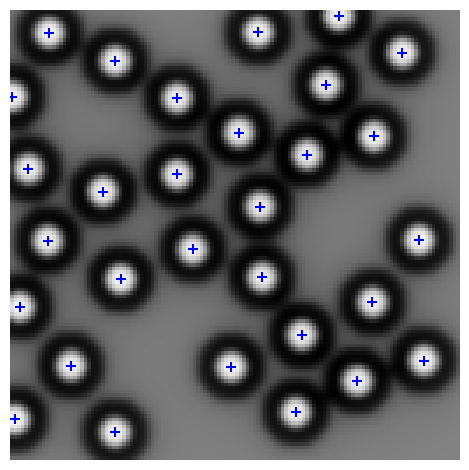

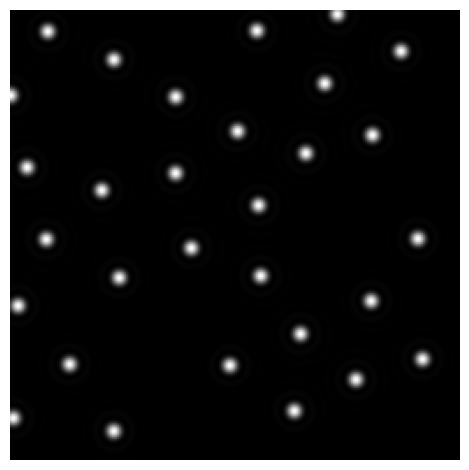

In [11]:
sim_image, sim_map = transform_to_video(gt_pos[np.newaxis, :], IMAGE_SIZE = 128)

plt.figure()

plt.imshow(sim_image, cmap="gray")
plt.scatter(
    gt_pos[:, 1],
    gt_pos[:, 0],
    s=50,
    c="b",
    marker='+'
)
plt.axis("off")

plt.tight_layout()
#plt.savefig('../figures/fig_20_04.png', dpi=300)
plt.show()


plt.figure()

plt.imshow(sim_map, cmap="gray")

plt.axis("off")

plt.tight_layout()
#plt.savefig('../figures/fig_20_04.png', dpi=300)
plt.show()

## 3. Localization and analysis

After generating a realistic simulation of the experiment, we can implement, evaluate and compare different detection algorithms. This is enabled by the fact that the ground truth —i.e., the actual particle positions— is known, allowing for a direct and precise comparison of the detection accuracy.

The following detection methods will be implemented and evaluated with respect to the ground truth:

1. Thresholding (using scikit regionprops)
2. Crocker and Grier (using trackpy)
3. UNet convolutional neural network (using DeepTrack)
4. Lodestar.

# Method 1: Thresholding and regionprops

The image is an intensity map, in which each point can have a fractional value. When normalized, the maximum in intensity corresponds to 1, corresponding to the strongest signal due to the presence of particles, while the minimum intensity is zero, corresponding to a dark area with no particles.

Thresholding method involves the creation of a mask, a minimalistic version of the intensity map with only binary values; 1 corresponding to the optical signal of a particle and 0 otherwise. 

To create a mask, we start by defining a intensity threshold between 0 and 1. Any value above this intensity threshold will be rounded up to 1, and lower values will be set to zero.

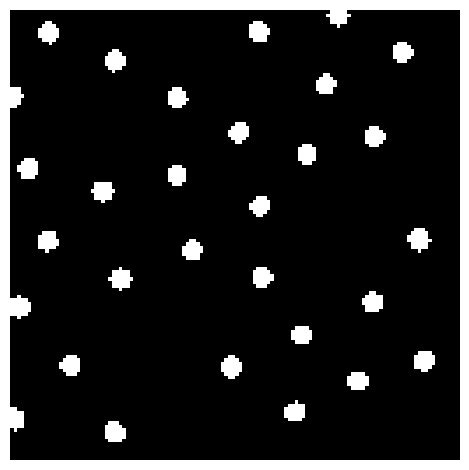

In [12]:
from cv2 import threshold, THRESH_BINARY
intensity_threshold = 0.75 # Minimum value to be considered as unity 
max_intensity = 1 # Any intensity value equal or greater than intensity_threshold willm be rounded up to max_intensity
_, mask_image = threshold(np.array(np.squeeze(sim_image)),intensity_threshold, max_intensity, THRESH_BINARY) # The mask is saved as mask_image, an intensity map with binary values.


# Display the mask
plt.figure()
plt.imshow(mask_image, cmap="gray")

plt.axis("off")

plt.tight_layout()
#plt.savefig('../figures/fig_20_04.png', dpi=300)
plt.show()

### Calculate the predicted positions from the mask.
A function to extract positions from the mask is defined. 

In [13]:
def mask_to_positions(mask):
    from skimage.measure import label, regionprops
    """Converts a mask to a list of positions"""
    
    # Label the mask
    ##  Determines the connectivity of pixels having the same value. 
    ### 1-connectivity refers to direct connections in x and y directions. 2-connectivity refers also includes diagonal connections
    #### All the connected regions are assigned the same value (position). 
    labels = label(mask)
    
    # Instance to measure properties of previously labelled regions
    props = regionprops(labels)
    
    # Extract the centroids of each labelled region
    mask_centroids = np.array([prop.centroid for prop in props])
    return mask_centroids

### Plot positions from ground truth and mask centroids for comparison

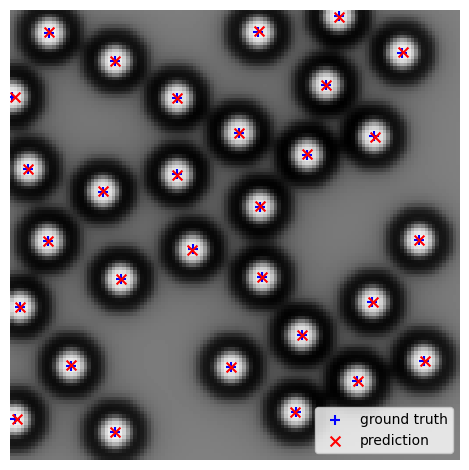

In [14]:
# Use the function to extract positions from mask
pred_pos_M1 = mask_to_positions(mask_image)

# Open figure instance
plt.figure()

# Display simulated image in grayscale
plt.imshow(sim_image, cmap="gray")

# Scatter plot of positions from ground truth
plt.scatter(
    gt_pos[:, 1],
    gt_pos[:, 0],
    s=50,
    c="b",
    marker='+',
    label='ground truth'

)

# Scartter plot of positions from mask centroids
plt.scatter(
    pred_pos_M1[:, 1],
    pred_pos_M1[:, 0],
    s=50,
    c="r",
    marker='x',
    label='prediction'
)

# Plotting options
plt.axis("off")
plt.legend()
plt.tight_layout()
#plt.savefig('../figures/fig_20_04.png', dpi=300)
plt.show()

## Evaluation of performance

A function to evaluate the performance is defined, so it can be applied to compare different methods with respect to the ground truth.
Distance between predicted and ground truth (true positions) are calculated.

In [15]:
def evaluate_locs(predicted_positions, true_positions, distance_th = 5):
    
    # INPUT:
        # predicted_positions: Positions calculated using some method
        # true_positions: Ground truth of positions from simulation
        # distance_th : Threshold distance 
    
    # OUTPUT:
        # TP: True Positives
        # FP: False Positives
        # FN: False Negatives
        # F!: F1 score, a measure of the performance and accuracy in machine learning models. Value 1 corresponds to perfect match and predictive power, 0 to no predictive power.
    
    
    # Initialize True Positive, False Positive, False Negative to zero
    TP = 0
    FP = 0
    FN = 0

    # Pair-wise distance is calculated between predicted positions and ground truth
    ## distance_matrix is a cost matrix, expressing the distance between positions
    distance_matrix = scipy.spatial.distance_matrix(predicted_positions, true_positions)
    
    # Solves the Linear Sum Assignment Problem to find and match the indices of the pair of particles that are the closest from each other
    ## The operation list(zip(row_ind, _col_ind)) gives the indices (i,j) of the ith predicted particle and the jth true particle, forming closest-neighbour couples.
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(distance_matrix)

    # Collect only the pair of particles closer than a certain user-defined threshold distance
    filtered_row_ind = row_ind[distance_matrix[row_ind, col_ind] < distance_th]
    filtered_col_ind = col_ind[distance_matrix[row_ind, col_ind] < distance_th]

    # Metrics to evaluate the performance
    TP += len(filtered_row_ind) # True positives 
    FP += len(predicted_positions) - len(filtered_row_ind) # False positives
    FN += len(true_positions) - len(filtered_col_ind) # False negatives

    RMSE = sum(distance_matrix[row_ind, col_ind])/TP # Root mean square error (in position)
    
    f1 = 2 * TP / (2 * TP + FP + FN) # F-score or F-measure is a measure of predictive performance or model accuracy. 

    print(
        f"""
        True positives: {TP}{'/'}{len(true_positions)}
        False positives: {FP}
        False negatives: {FN}
        F1 score: {f1}
        RMSE: {RMSE}"""
    )
    return TP, FP, FN, f1, RMSE

### Apply the function to evaluate performance the thresholding method

In [16]:
_,_,_,_,_ = evaluate_locs(pred_pos_M1, gt_pos, distance_th = 5)


        True positives: 30/30
        False positives: 0
        False negatives: 0
        F1 score: 1.0
        RMSE: 0.17627920405269482


## Bonus: Use radial symmetry to refine localization

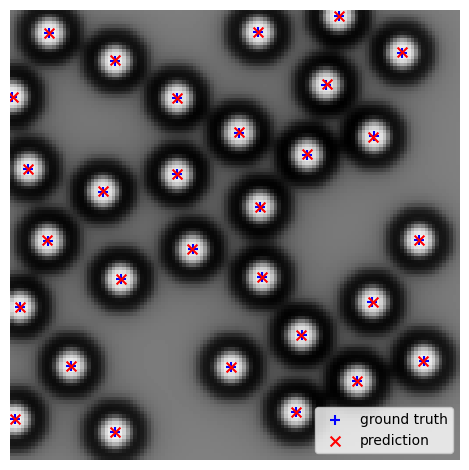


        True positives: 30/30
        False positives: 0
        False negatives: 0
        F1 score: 1.0
        RMSE: 0.10919378033943881


In [17]:
from deeptrack.extras.radialcenter import radialcenter as rc

roi_size = 24
pred_pos_M1_ref=[]

for x,y in pred_pos_M1:
    roi = sim_image[int(max(0,np.floor(x)-roi_size//2)):int(min(np.floor(x)+roi_size//2,sim_image.shape[0])), int(max(0,np.floor(y)-roi_size//2)):int(min(np.floor(y)+roi_size//2,sim_image.shape[1])),0 ]
    xc, yc = rc(roi, invert_xy=True)
    pred_pos_M1_ref.append([int(max(0,np.floor(x)-roi_size//2))+xc, int(max(0,np.floor(y)-roi_size//2))+yc])


# for x,y in pred_pos_M1:
#     roi = sim_image[max(0,round(x)-roi_size//2):min(round(x)+roi_size//2,sim_image.shape[0]), max(0,round(y)-roi_size//2):min(round(y)+roi_size//2,sim_image.shape[1]) ,0]
#     xc, yc, _, _ = radialcenter(roi)
#     pred_pos_M1_ref.append([max(0,round(x)-roi_size//2)+xc-0.5, max(0,round(y)-roi_size//2)+yc-0.5])

pred_pos_M1_ref=np.array(pred_pos_M1_ref)


plt.figure()

plt.imshow(sim_image, cmap="gray")
plt.scatter(
    gt_pos[:, 1],
    gt_pos[:, 0],
    s=50,
    c="b",
    marker='+',
    label='ground truth'

)

plt.scatter(
    pred_pos_M1_ref[:, 1],
    pred_pos_M1_ref[:, 0],
    s=50,
    c="r",
    marker='x',
    label='prediction'
)
plt.axis("off")
plt.legend()
plt.tight_layout()
#plt.savefig('../figures/fig_20_04.png', dpi=300)
plt.show()

_,_,_,_,_ = evaluate_locs(pred_pos_M1_ref, gt_pos, distance_th = 5)

### Apply the threshold method to loaded experimental data

In [2]:
# Apply the threshold method to loaded file 
_, mask_exp = threshold(np.array(np.squeeze(image/255.)),0.1, 1, THRESH_BINARY)

pred_pos_M1_exp = mask_to_positions(mask_exp)

plt.figure()

plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")

plt.scatter(
    pred_pos_M1_exp[:, 1],
    pred_pos_M1_exp[:, 0],
    s=20,
    c="r",
    marker='x',
)
plt.axis("off")
#plt.savefig('../figures/fig_20_04.png', dpi=300)


plt.subplot(1, 2, 2)

plt.imshow(mask_exp, cmap="gray")

plt.axis("off")

plt.tight_layout()
#plt.savefig('../figures/fig_20_04.png', dpi=300)
plt.show()


NameError: name 'threshold' is not defined

# Method 2: Crocker and Grier (using trackpy)

### This method locates Gaussian-like bumps in an intensity map. It requires a user-defined approximate radius which relates to the FWHM of the Gaussian signal. 

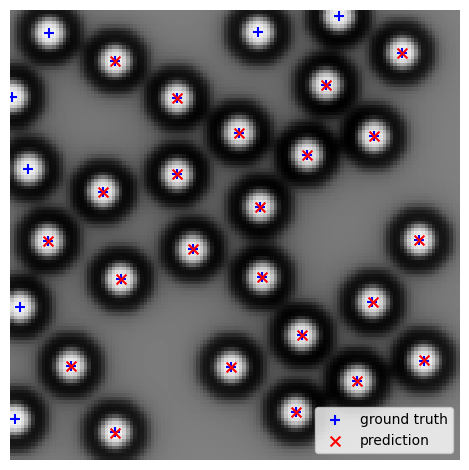


        True positives: 23/30
        False positives: 0
        False negatives: 7
        F1 score: 0.8679245283018868
        RMSE: 0.03640869699250327


In [19]:
import trackpy as tp

# Estimated size of particle optical signal
estimated_radius = 15

# Invert = False corresponds to particles brighter than background. True if particles are darker than background
f = tp.locate(sim_image, estimated_radius, invert=False)

# Convert f dataframe to numpy array
pred_pos_M2 = np.array(f)[:,:2]

# Initialize figure instance to plot the image and the predicted and simulated particle locations
plt.figure()
plt.imshow(sim_image, cmap="gray")

# Ground truth 
plt.scatter(
    gt_pos[:, 1],
    gt_pos[:, 0],
    s=50,
    c="b",
    marker='+',
    label='ground truth'

)

# Predicted locations by trackpy.locate
plt.scatter(
    pred_pos_M2[:, 1],
    pred_pos_M2[:, 0],
    s=50,
    c="r",
    marker='x',
    label='prediction'
)

# Plot settings
plt.axis("off")
plt.legend()
plt.tight_layout()
#plt.savefig('../figures/fig_20_04.png', dpi=300)
plt.show()

# Evaluate the performance of tp.locate
_,_,_,_,_ = evaluate_locs(pred_pos_M2, gt_pos, distance_th = 5)

### 

## Apply to experimental image

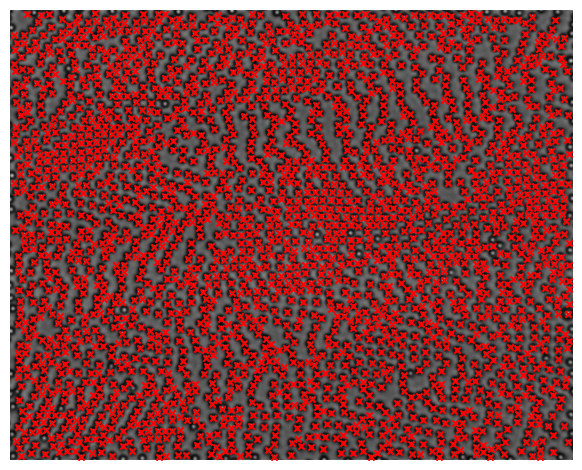

In [20]:
# Use Trackpy.locate to experimental data file 'image'
f = tp.locate(image, estimated_radius, invert=False)
pred_pos_M2_exp = np.array(f)[:,:2]

# Plot the experimental image
plt.figure()
plt.imshow(image, cmap="gray")

# Plot the predicted positions 
plt.scatter(
    pred_pos_M2_exp[:, 1],
    pred_pos_M2_exp[:, 0],
    s=20,
    c="r",
    marker='x',
)

# Plot settings
plt.axis("off")
plt.tight_layout()
#plt.savefig('../figures/fig_20_04.png', dpi=300)
plt.show()


# Method 3: UNet

UNet is a convolutional neural network, a type of deep learning model, used to efficiently segment a large image. It is useful to assign a class label to each pixel in an image, e.g., to determine whether a pixel is part of the background or an object, and label the pixel accordingly. The prefix "U" stands for the architecture of the network, in which the layers associated with the encoder and decoder are symmetric, and the intermediate layers are smaller in size and function as a bottleneck

### Create a training dataset

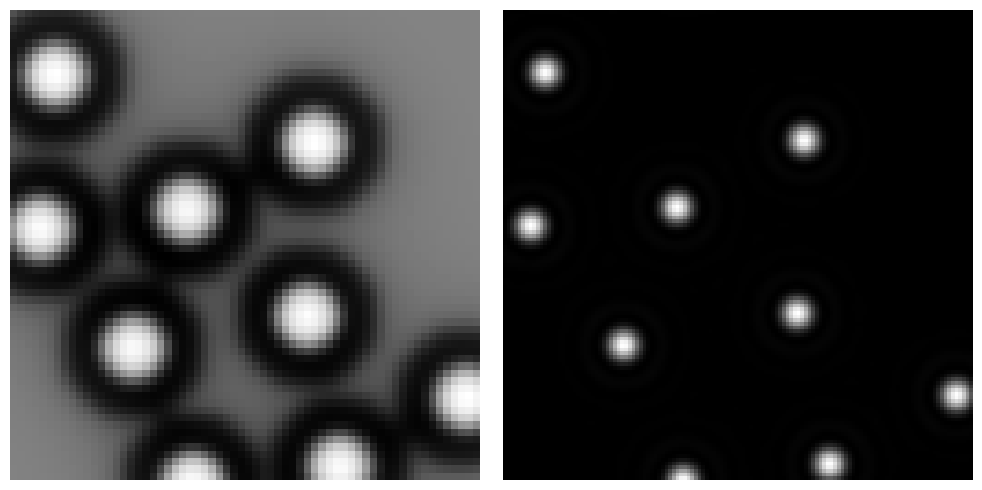

In [21]:
# A dataset of 32 samples will be generated
Nsamples = 32 
# Number of pixels is IM_SIZE x IM_SIZE
IM_SIZE=64
# Empty variables to store the data of each sample
images = []
maps = []


for _ in range(Nsamples):
    # Generate the ground truth of positions using steepest descent of LJ potential to generate physically plausible scenarios
    _gt_pos = generate_centroids(num_of_particles = [5,10],radius= 10, show=False, BoxSize=IM_SIZE)
    # Convert the positions to images
    _sim_image, _sim_map = transform_to_video(_gt_pos[np.newaxis, :], IMAGE_SIZE = IM_SIZE)
    # Collect the image of every sample
    images.append(_sim_image)
    
    maps.append(_sim_map)
# Images    
images=np.array(images)
maps=np.array(maps)


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(images[0]), cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(maps[0]), cmap="gray")
plt.axis("off")

plt.axis("off")

plt.tight_layout()
#plt.savefig('../figures/fig_20_04.png', dpi=300)
plt.show()

### Define a shallow UNet

In [22]:
from deeptrack.models import UNet
from deeptrack.layers import  StaticUpsampleBlock


model = UNet(
    input_shape=(None, None, 1),
    conv_layers_dimensions=(16, 32),
    base_conv_layers_dimensions=(64, 64),
    output_conv_layers_dimensions=(16,),
    output_convolution_block = "deconvolutional",
    output_activation="linear",

)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 1)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 16)       160       ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, None, None, 16)       0         ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, None, None, 16)       0         ['activation[0][0]']          
 D)                                                                                           

### Compile the model

In [23]:
from tensorflow.keras.losses import MSE
model.compile(
    loss=MSE,  
    optimizer="adam",
    metrics=["mse"],
    )

### Training pipeline and generator

In [24]:
selector = dt.Lambda(lambda i: lambda x: x[i],  i = lambda l: np.random.randint(l), l=len(images))

pipeline  = (dt.Value(images) & dt.Value(maps))  >> dt.NormalizeMinMax(0,1)  >> selector

generator = dt.generators.ContinuousGenerator(
    pipeline,
    min_data_size=int(64), 
    max_data_size=int(65),
    batch_size=8,
)

### Check pipeline

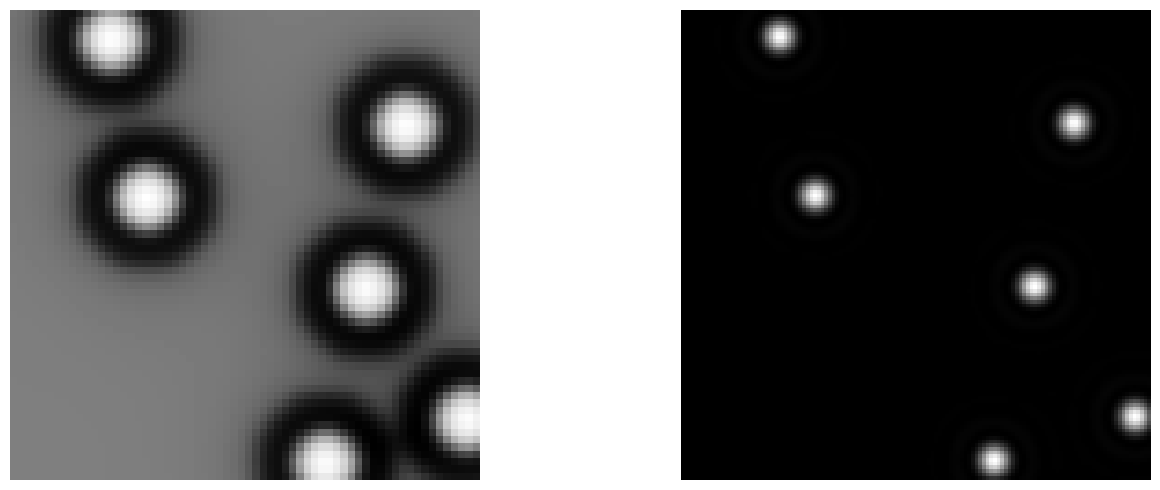

In [25]:
test, t_map = pipeline.update()()
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(test, cmap='gray')

plt.axis('off')


plt.subplot(1, 2, 2)
plt.imshow(t_map, cmap='gray')
plt.axis('off')

plt.tight_layout()
#plt.savefig('../figures/fig_20_03.png', dpi=300)
plt.show()

### Train the UNet

In [26]:
with generator:
    model.fit(
        generator,
        epochs=30, 
    )

Generating 65 / 64 samples before starting training
Epoch 1/30
8/8 [==============================] - 11s 200ms/step - loss: 0.0090 - mse: 0.0090
Epoch 2/30
8/8 [==============================] - 2s 242ms/step - loss: 0.0077 - mse: 0.0077
Epoch 3/30
8/8 [==============================] - 2s 208ms/step - loss: 0.0062 - mse: 0.0062
Epoch 4/30
8/8 [==============================] - 2s 207ms/step - loss: 0.0034 - mse: 0.0034
Epoch 5/30
8/8 [==============================] - 2s 213ms/step - loss: 0.0014 - mse: 0.0014
Epoch 6/30
8/8 [==============================] - 2s 207ms/step - loss: 7.7638e-04 - mse: 7.7638e-04
Epoch 7/30
8/8 [==============================] - 2s 211ms/step - loss: 4.7021e-04 - mse: 4.7021e-04
Epoch 8/30
8/8 [==============================] - 2s 228ms/step - loss: 2.9115e-04 - mse: 2.9115e-04
Epoch 9/30
8/8 [==============================] - 2s 223ms/step - loss: 2.2781e-04 - mse: 2.2781e-04
Epoch 10/30
8/8 [==============================] - 1s 160ms/step - loss: 1.785

### Alternative training

In [27]:
#model.fit(
#    pipeline,
#    epochs=10, 
#    batch_size = 8,
#    generator_kwargs={
#    "min_data_size": int(64),
#    "max_data_size": int(65),
#  } 
#)

### Test and evaluation

In [28]:
#test, t_map = pipeline.update()()
from deeptrack.extras.radialcenter import radialcenter  as rc

# Apply threshold method to UNet model
pred_map = model.predict(sim_image[np.newaxis])
pred_map = np.array(np.squeeze(pred_map))
_, im_b = threshold(pred_map,0.1, 1, THRESH_BINARY)
pred_pos_M3 = mask_to_positions(im_b)
_,_,_,_,_ = evaluate_locs(pred_pos_M3/2, gt_pos, distance_th = 5)

#
roi_size = 31
pred_pos_M3_ref=[]
for x,y in pred_pos_M3:
    roi = sim_map[int(max(0,np.floor(x)-roi_size//2)):int(min(np.floor(x)+roi_size//2,sim_map.shape[0])), int(max(0,np.floor(y)-roi_size//2)):int(min(np.floor(y)+roi_size//2,sim_map.shape[1])) ]
    xc, yc = rc(roi, invert_xy=True)
    pred_pos_M3_ref.append([int(max(0,np.floor(x)-roi_size//2))+xc, int(max(0,np.floor(y)-roi_size//2))+yc])

pred_pos_M3_ref=np.array(pred_pos_M3_ref)

_,_,_,_,_ = evaluate_locs(pred_pos_M3_ref/2, gt_pos, distance_th = 5)

1/1 [==============================] - 0s 356ms/step

        True positives: 30/30
        False positives: 0
        False negatives: 0
        F1 score: 1.0
        RMSE: 0.23830477546487405

        True positives: 30/30
        False positives: 0
        False negatives: 0
        F1 score: 1.0
        RMSE: 0.17901931572888283


### Display the simulated image, the mask of the prediction from the UNet model

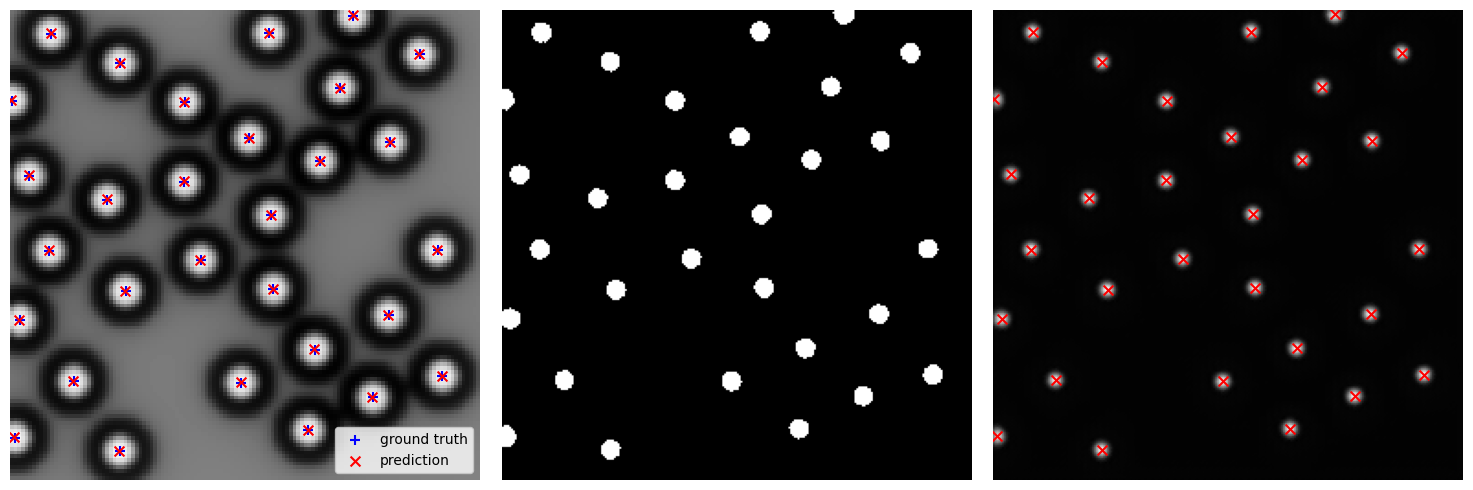

In [29]:
plt.figure(figsize=(15, 5))

# Simulation with DeepTrack using ground truth
plt.subplot(1, 3, 1)
plt.imshow(sim_image, cmap='gray')
plt.scatter(
   gt_pos[:,1],
   gt_pos[:,0], 
   s=50,
   c="b",
   marker='+',
   label='ground truth'
)

plt.scatter(
    pred_pos_M3_ref[:, 1]/2,
    pred_pos_M3_ref[:, 0]/2,
    s=50,
    c="r",
    marker='x',
    label='prediction'
)

plt.axis('off')
plt.legend()

plt.subplot(1, 3, 2) 
plt.imshow(im_b, cmap='gray')
plt.axis('off')
#plt.text(5, 15, 'b', fontsize=20, fontweight='bold', color='white')


plt.subplot(1, 3, 3)
plt.imshow(pred_map, cmap='gray')
plt.axis('off')
plt.tight_layout()


plt.scatter(
    pred_pos_M3_ref[:, 1],
    pred_pos_M3_ref[:, 0],
    s=50,
    c="r",
    marker='x',
    label='prediction'
)
plt.axis('off')


plt.tight_layout()
#plt.savefig('../figures/fig_20_03.png', dpi=300)
plt.show()

### Apply to experimental data

In [30]:
normalization = dt.NormalizeMinMax(0,1)
pred = model.predict(np.reshape(normalization(image), (1, image.shape[0],image.shape[1], 1)))
pred = np.array(np.squeeze(pred))
_, im_b = threshold(pred,0.01, 1, THRESH_BINARY)
pred_pos_M3_exp = mask_to_positions(im_b)/2

1/1 [==============================] - 2s 2s/step


### Visualize the experimental data and the prediction

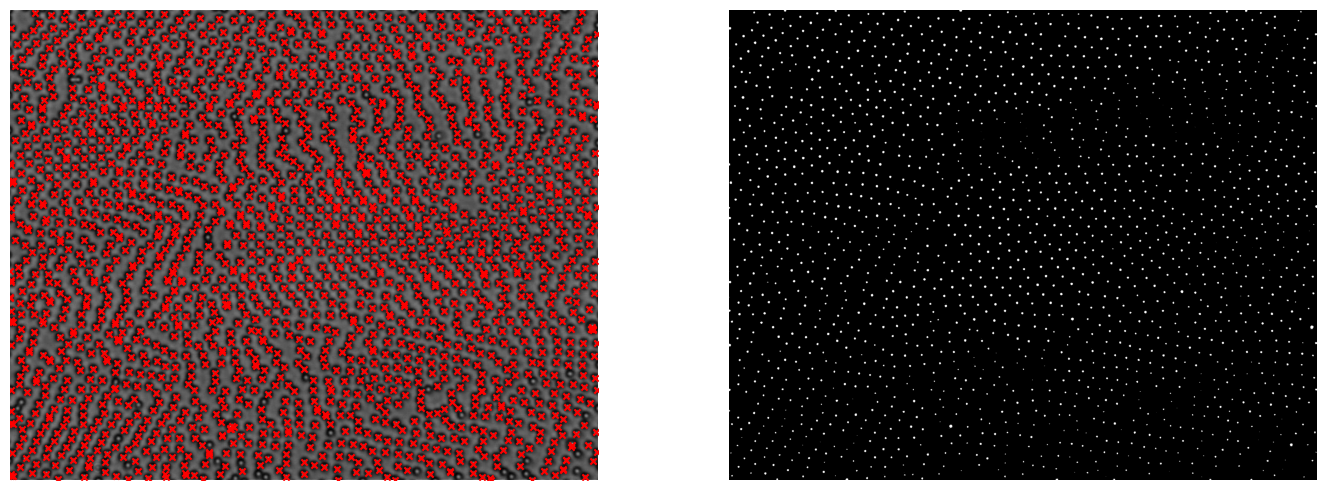

In [31]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
#plt.imshow(pred, cmap='gray')

plt.scatter(
    pred_pos_M3_exp[:, 1],
    pred_pos_M3_exp[:, 0],
    s=20,
    c="r",
    marker='x',
    label='prediction'
)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(im_b, cmap='gray')
plt.axis('off')

plt.tight_layout()
#plt.savefig('../figures/fig_20_03.png', dpi=300)
plt.show()

# Method 4: LodeSTAR

### Localization and Detection from Symmetries, Translations And Rotations 

### Define a one-shot training set and augmentation

In [32]:
augmentations = optics(combined_sphere) >> dt.Divide(lambda: scale_factor*np.random.uniform(.9, 1.1))  >> dt.Add(lambda: 80 + np.random.uniform(-5, 5)) >> dt.Gaussian(0,.5)
normalization = dt.Divide(255)

training_pipeline = augmentations >> normalization

### Check augmentations

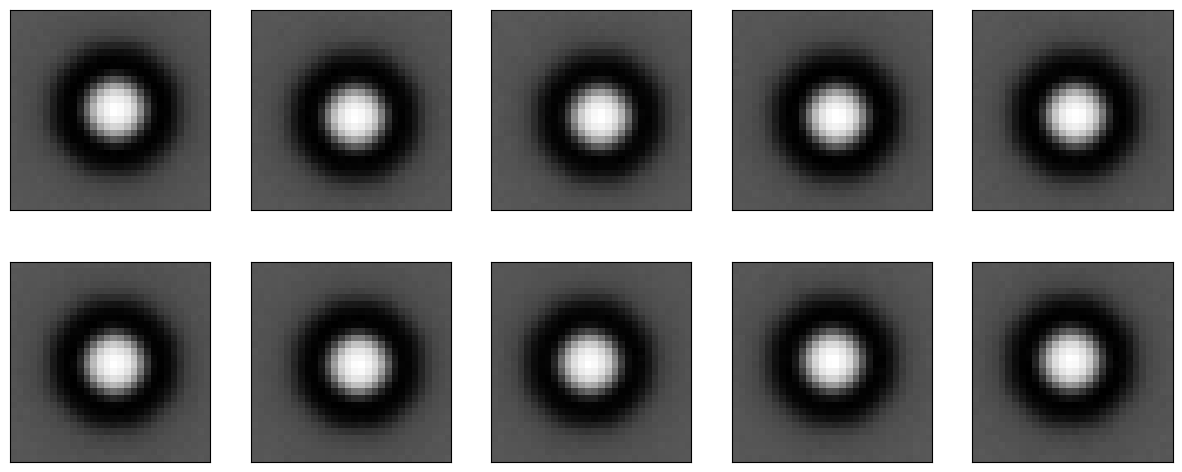

In [33]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flatten()):
    sim=training_pipeline.update()()
    ax.imshow(np.squeeze(sim), cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])

### Define the model and train

In [34]:
model = dt.models.LodeSTAR()

model.fit(
	training_pipeline,
	epochs=50,
	batch_size=8,
	steps_per_epoch=100,
)

Generating 162 / 160 samples before starting training
Epoch 1/50
100/100 [==============================] - 15s 94ms/step - total_loss: 2.2388 - consistency_loss: 1.0280
Epoch 2/50
100/100 [==============================] - 7s 72ms/step - total_loss: 2.3439 - consistency_loss: 0.6252
Epoch 3/50
100/100 [==============================] - 7s 73ms/step - total_loss: 1.9145 - consistency_loss: 0.4717
Epoch 4/50
100/100 [==============================] - 8s 79ms/step - total_loss: 0.2264 - consistency_loss: 0.0664
Epoch 5/50
100/100 [==============================] - 8s 80ms/step - total_loss: 0.0786 - consistency_loss: 0.0139
Epoch 6/50
100/100 [==============================] - 8s 76ms/step - total_loss: 0.0725 - consistency_loss: 0.0081
Epoch 7/50
100/100 [==============================] - 7s 65ms/step - total_loss: 0.0688 - consistency_loss: 0.0077
Epoch 8/50
100/100 [==============================] - 6s 58ms/step - total_loss: 0.0582 - consistency_loss: 0.0060
Epoch 9/50
100/100 [=====

### Save/load model

In [35]:
model.save_weights("lodestar/weights")
#model.load_weights("weights")

### Pick image for test and predict features

In [36]:
test_image = np.reshape(sim_image, (1, sim_image.shape[0],sim_image.shape[1], 1))

position_feature, mass_feature = model.predict(test_image)

1/1 [==============================] - 1s 563ms/step


### Display predicted features

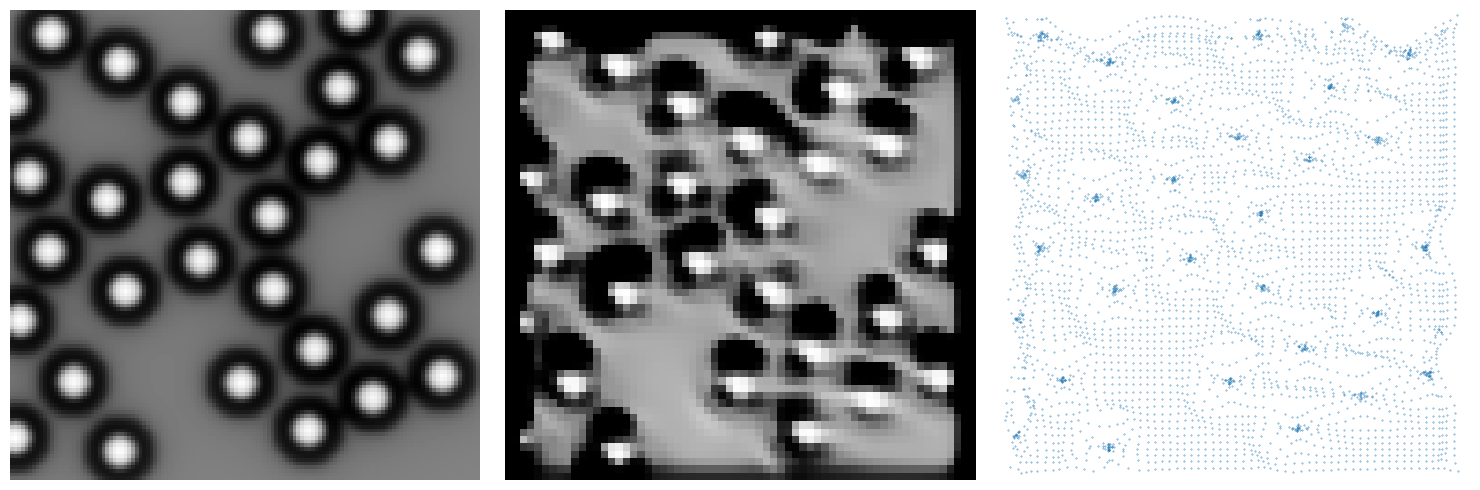

In [37]:
plt.figure(figsize=(15, 5))


plt.subplot(1, 3, 1)
plt.imshow(sim_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mass_feature[0], cmap='gray')
plt.axis('off')
#plt.text(5, 15, 'b', fontsize=20, fontweight='bold', color='white')

plt.subplot(1, 3, 3)
plt.scatter(
   position_feature[0, :, :, 1].flatten(),
   position_feature[0, :, :, 0].flatten(), 
   alpha=0.9,
   s=.1,
)
plt.xlim(0, sim_image.shape[0])
plt.ylim(0, sim_image.shape[1])
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')
#plt.text(10, 30, 'c', fontsize=20, fontweight='bold', color='black')
plt.axis('off')

plt.tight_layout()
#plt.savefig('../figures/fig_20_03.png', dpi=300)
plt.show()

### Predict positions

In [38]:
pred_pos_M4 = model.predict_and_detect(
    test_image, 
    alpha=0.1,
    beta=0.9,
    mode = 'constant',
    cutoff=0.1
)[0]

1/1 [==============================] - 0s 124ms/step


### Overlay detections to test image

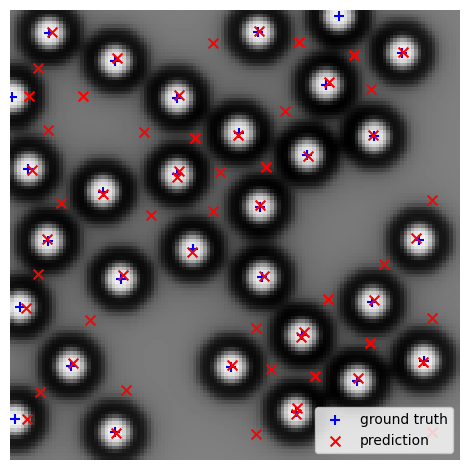


        True positives: 29/30
        False positives: 32
        False negatives: 1
        F1 score: 0.6373626373626373
        RMSE: 1.3858305141941276


In [39]:
plt.figure()
plt.imshow(sim_image, cmap="gray")
plt.scatter(
    gt_pos[:, 1],
    gt_pos[:, 0],
    s=50,
    c="b",
    marker='+',
    label='ground truth'
)

plt.scatter(
    pred_pos_M4[:, 1],
    pred_pos_M4[:, 0],
    s=50,
    c="r",
    marker='x',
    label='prediction'
)
plt.axis("off")
plt.legend()
plt.tight_layout()
#plt.savefig('../figures/fig_20_04.png', dpi=300)
plt.show()

_,_,_,_,_ = evaluate_locs(pred_pos_M4, gt_pos, distance_th = 5)

### Transfer learning to experiment image

In [40]:
pred_pos_M4_exp = model.predict_and_detect(
    np.reshape(normalization(image), (1, image.shape[0],image.shape[1], 1)), 
    alpha=0.1,
    beta=0.9,
    mode = 'constant',
    cutoff=0.1
)[0]

1/1 [==============================] - 3s 3s/step


### Display prediction on experiment image

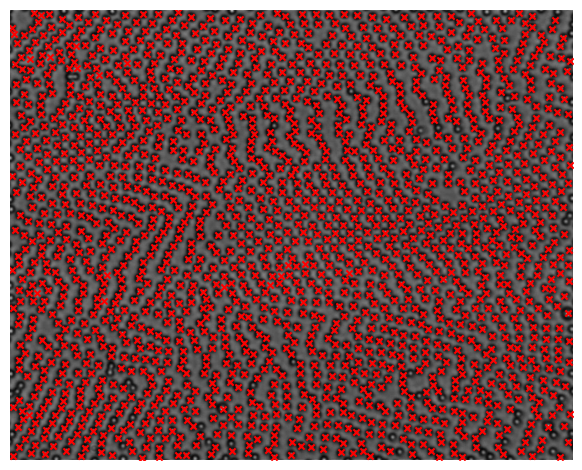

In [41]:
plt.figure()

plt.imshow(image, cmap="gray")
plt.scatter(
    pred_pos_M4_exp[:, 1],
    pred_pos_M4_exp[:, 0],
    s=20,
    c="r",
    marker='x'
)
plt.axis("off")

plt.tight_layout()
#plt.savefig('../figures/fig_20_04.png', dpi=300)
plt.show()

### LodeSTAR only needs one experimental image

In [42]:
normalization = dt.Divide(255)
value = dt.Value(lambda: np.array(crop))

augmentations = (
    dt.FlipLR() >> dt.FlipUD() >>dt.FlipDiagonal()
    >> dt.Multiply(lambda: np.random.uniform(0.8, 1.2))
    >> dt.Add(lambda: np.random.uniform(-0.1, 0.1))
    
)

training_pipeline = value >> normalization >> augmentations

### Check augmentation

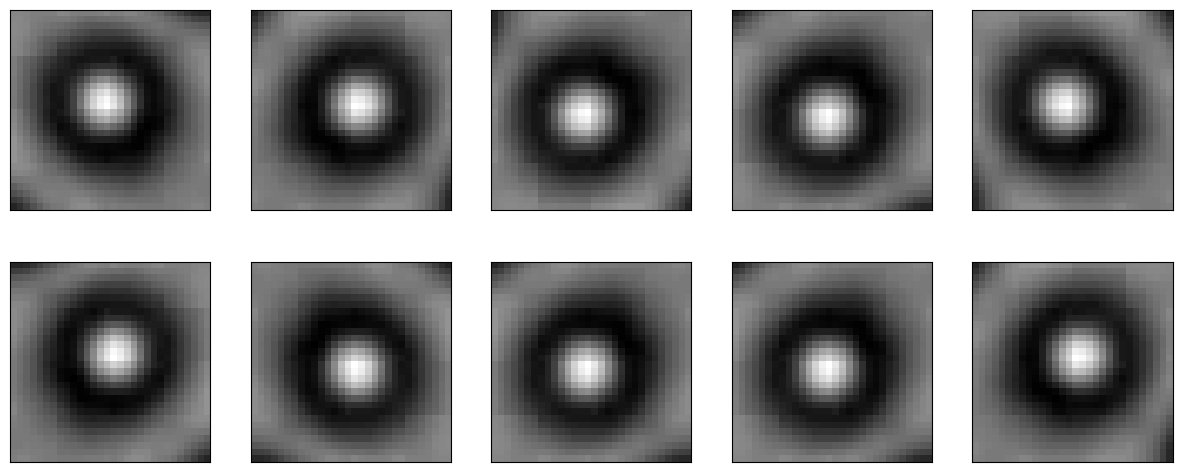

In [43]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flatten()):
    sim=training_pipeline.update()()
    ax.imshow(np.squeeze(sim), cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])

In [44]:
model2 = dt.models.LodeSTAR()

model2.fit(
	training_pipeline,
	epochs=50,
	batch_size=8,
	steps_per_epoch=100,
)

Generating 171 / 160 samples before starting training
Epoch 1/50
100/100 [==============================] - 22s 96ms/step - total_loss: 2.2178 - consistency_loss: 1.1260
Epoch 2/50
100/100 [==============================] - 6s 58ms/step - total_loss: 1.5229 - consistency_loss: 0.8418
Epoch 3/50
100/100 [==============================] - 7s 66ms/step - total_loss: 0.8325 - consistency_loss: 0.5586
Epoch 4/50
100/100 [==============================] - 6s 65ms/step - total_loss: 0.6021 - consistency_loss: 0.3188
Epoch 5/50
100/100 [==============================] - 7s 69ms/step - total_loss: 0.2073 - consistency_loss: 0.0563
Epoch 6/50
100/100 [==============================] - 7s 69ms/step - total_loss: 0.0952 - consistency_loss: 0.0117
Epoch 7/50
100/100 [==============================] - 7s 66ms/step - total_loss: 0.0598 - consistency_loss: 0.0083
Epoch 8/50
100/100 [==============================] - 5s 54ms/step - total_loss: 0.0596 - consistency_loss: 0.0075
Epoch 9/50
100/100 [=====

### Predict coordinates

In [45]:
pred_pos_M4_exp2 = model2.predict_and_detect(
    np.reshape(normalization(image), (1, image.shape[0],image.shape[1], 1)), 
    alpha=0.1,
    beta=0.9,
    mode = 'constant',
    cutoff=0.1
)[0]

1/1 [==============================] - 2s 2s/step


### Display results

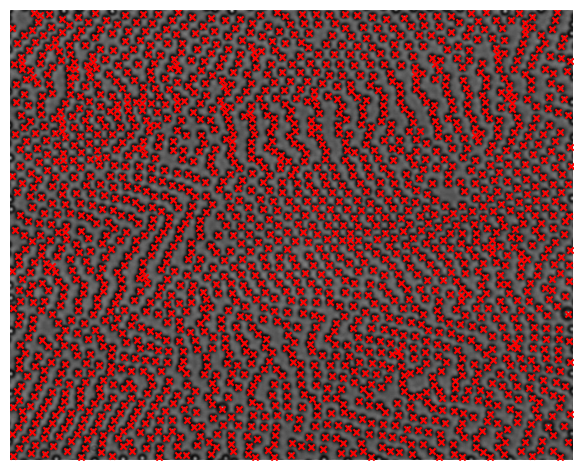

: 

In [46]:
plt.figure()

plt.imshow(image, cmap="gray")
plt.scatter(
    pred_pos_M4_exp2[:, 1],
    pred_pos_M4_exp2[:, 0],
    s=20,
    c="r",
    marker='x'
)
plt.axis("off")

plt.tight_layout()
#plt.savefig('../figures/fig_20_04.png', dpi=300)
plt.show()

### Select the crops iteratively 

import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt

crops=np.empty([0,width,width])

plt.figure(figsize=(12, 12))
plt.imshow(image, cmap="gray")
plt.axis("off")
x=plt.ginput(n=-1, timeout=-1,show_clicks=True)


for i, val in enumerate(x):
    crops=np.append(crops, np.array([image[int(val[1])-width//2:int(val[1])+width//2, int(val[0])-width//2:int(val[0])+width//2]]),0)


### Check crops

In [1]:
%matplotlib inline
fig, axes = plt.subplots(1, crops.shape[0], figsize=(15, 6))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(np.squeeze(crops[i,:,:]), cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])


NameError: name 'plt' is not defined